In [14]:
import os
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# """ cache = True saves the data in C:\Users\AJ24032\scikit_learn_data """
mnist = fetch_openml('mnist_784', as_frame=False, cache=True)

In [19]:
# Convert mnist.data to integers
mnist.data = mnist.data.astype(int)

# Convert mnist.target to integers
mnist.target = mnist.target.astype(int)

# Verify the shape of the data and target
print("Data shape:", mnist.data.shape)
print("Target shape:", mnist.target.shape)

# Optionally, check the first few records
print("First few records of data:", mnist.data[:5])
print("First few target values:", mnist.target[:5])
print("type(mnist.target[1]): " + str(type(mnist.target[1])))

# Get the current working directory
current_directory = os.getcwd()
print("Current Working Directory:", current_directory)


Data shape: (70000, 784)
Target shape: (70000,)
First few records of data: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
First few target values: [5 0 4 1 9]
type(mnist.target[1]): <class 'numpy.int32'>
Current Working Directory: c:\Users\AJ24032\Documents\Mauricio\0_Practice\Python\1. Deep Learning\6_minst_num_reading_nn


In [17]:
dataset = mnist.data[:1000]

def get_image_section(layer,row_from, row_to, col_from, col_to):
    sub_section = layer[:,row_from:row_to,col_from:col_to]
    return sub_section.reshape(-1,1,row_to-row_from, col_to-col_from)

# Define network parameters
hidden_size = 128
pixels_per_image, num_labels = 784, 10
alpha, iterations, batch_size = 0.01, 2000, 100

kernel_rows, kernel_cols = [3, 3]

# Training loop
for j in range(iterations):
    error, correct_cnt = 0.0, 0
    
    for i in range(int(len(dataset) / batch_size)):
        batch_start, batch_end = i * batch_size, (i + 1) * batch_size

        layer_0 = dataset[batch_start:batch_end]
        layer_0 = layer_0.reshape(layer_0.shape[0],28,28)
        layer_0.shape
        sects = list()
        for row_start in range(layer_0.shape[1]-kernel_rows):
            for col_start in range(layer_0.shape[2] - kernel_cols):
                sect = get_image_section(layer_0,
                row_start,
                row_start+kernel_rows,
                col_start,
                col_start+kernel_cols)
            sects.append(sect)
        expanded_input = np.concatenate(sects,axis=1)
        es = expanded_input.shape
        flattened_input = expanded_input.reshape(es[0]*es[1],-1)

In [73]:
import numpy as np
import sys
from sklearn.datasets import fetch_openml

np.random.seed(1)

# Preprocess training data
images = np.array(mnist.data[:2000], dtype=float).reshape(2000, 28, 28) / 255.0
labels = mnist.target[:2000].astype(int)
one_hot_labels = np.zeros((len(labels), 10))
for i, l in enumerate(labels):
    one_hot_labels[i][l] = 1
labels = one_hot_labels

# Preprocess test data
test_images = np.array(mnist.data[3000:4000], dtype=float).reshape(1000, 28, 28) / 255.0
test_labels_raw = mnist.target[3000:4000].astype(int)
test_labels = np.zeros((len(test_labels_raw), 10))
for i, l in enumerate(test_labels_raw):
    test_labels[i][l] = 1

# Activation functions
def tanh(x):
    return np.tanh(x)

def tanh2deriv(output):
    return 1 - (output ** 2)

def softmax(x):
    temp = np.exp(x)
    return temp / np.sum(temp, axis=1, keepdims=True)

# Hyperparameters
alpha = 10
iterations = 70
pixels_per_image = 784
num_labels = 10
batch_size = 128
input_rows = 28
input_cols = 28
kernel_rows = 3
kernel_cols = 3
num_kernels = 16
hidden_size = ((input_rows - kernel_rows) * (input_cols - kernel_cols)) * num_kernels

# Initialize weights
kernels = 0.02 * np.random.random((kernel_rows * kernel_cols, num_kernels)) - 0.01
weights_1_2 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1

def get_image_section(layer, row_from, row_to, col_from, col_to):
    section = layer[:, row_from:row_to, col_from:col_to]
    return section.reshape(-1, 1, row_to - row_from, col_to - col_from)

for j in range(iterations):
    correct_cnt = 0
    for i in range(int(len(images) / batch_size)):
        batch_start, batch_end = ((i * batch_size), ((i + 1) * batch_size))
        layer_0 = images[batch_start:batch_end]
        
        sects = []
        for row_start in range(layer_0.shape[1] - kernel_rows):
            for col_start in range(layer_0.shape[2] - kernel_cols):
                sect = get_image_section(layer_0, row_start, row_start + kernel_rows, col_start, col_start + kernel_cols)
                sects.append(sect)
        
        expanded_input = np.concatenate(sects, axis=1)
        es = expanded_input.shape
        flattened_input = expanded_input.reshape(es[0] * es[1], -1)
        kernel_output = flattened_input.dot(kernels)
        layer_1 = tanh(kernel_output.reshape(es[0], -1))
        
        dropout_mask = np.random.randint(2, size=layer_1.shape)
        layer_1 *= dropout_mask * 2
        layer_2 = softmax(np.dot(layer_1, weights_1_2))
        
        for k in range(batch_size):
            labelset = labels[batch_start + k:batch_start + k + 1]
            _inc = int(np.argmax(layer_2[k:k + 1]) == np.argmax(labelset))
            correct_cnt += _inc
        
        layer_2_delta = (labels[batch_start:batch_end] - layer_2) / (batch_size * layer_2.shape[0])
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * tanh2deriv(layer_1)
        layer_1_delta *= dropout_mask
        
        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
        l1d_reshape = layer_1_delta.reshape(kernel_output.shape)
        k_update = flattened_input.T.dot(l1d_reshape)
        kernels -= alpha * k_update

    test_correct_cnt = 0
    for i in range(len(test_images)):
        layer_0 = test_images[i:i + 1]
        
        sects = []
        for row_start in range(layer_0.shape[1] - kernel_rows):
            for col_start in range(layer_0.shape[2] - kernel_cols):
                sect = get_image_section(layer_0, row_start, row_start + kernel_rows, col_start, col_start + kernel_cols)
                sects.append(sect)
        
        expanded_input = np.concatenate(sects, axis=1)
        es = expanded_input.shape
        flattened_input = expanded_input.reshape(es[0] * es[1], -1)
        kernel_output = flattened_input.dot(kernels)
        layer_1 = tanh(kernel_output.reshape(es[0], -1))
        layer_2 = np.dot(layer_1, weights_1_2)
        
        test_correct_cnt += int(np.argmax(layer_2) == np.argmax(test_labels[i:i + 1]))
    
    if j % 1 == 0:
        sys.stdout.write("\n" +
                         "I:" + str(j) +
                         " Test-Acc:" + str(test_correct_cnt / float(len(test_images))) +
                         " Train-Acc:" + str(correct_cnt / float(len(images))))

# Save the weights
print("\n")
formatted_error = f"{correct_cnt / float(len(images)):.4f}".replace('.', '-')
np.savetxt(f"conv_filters_iter{iterations}_err{formatted_error}_cnn.csv", kernels.reshape(num_kernels, -1), delimiter=",")
np.savetxt(f"weights_1_2_iter{iterations}_err{formatted_error}_cnn.csv", weights_1_2, delimiter=",")
print(f"conv_filters_iter{iterations}_err{formatted_error}_cnn.csv")
print(f"weights_1_2_iter{iterations}_err{formatted_error}_cnn.csv")


I:0 Test-Acc:0.347 Train-Acc:0.0815
I:1 Test-Acc:0.013 Train-Acc:0.2915
I:2 Test-Acc:0.64 Train-Acc:0.107
I:3 Test-Acc:0.804 Train-Acc:0.538
I:4 Test-Acc:0.803 Train-Acc:0.655
I:5 Test-Acc:0.816 Train-Acc:0.697
I:6 Test-Acc:0.836 Train-Acc:0.743
I:7 Test-Acc:0.861 Train-Acc:0.7345
I:8 Test-Acc:0.863 Train-Acc:0.768
I:9 Test-Acc:0.881 Train-Acc:0.7735
I:10 Test-Acc:0.87 Train-Acc:0.7895
I:11 Test-Acc:0.875 Train-Acc:0.794
I:12 Test-Acc:0.876 Train-Acc:0.7925
I:13 Test-Acc:0.883 Train-Acc:0.8
I:14 Test-Acc:0.883 Train-Acc:0.807
I:15 Test-Acc:0.891 Train-Acc:0.82
I:16 Test-Acc:0.899 Train-Acc:0.8185
I:17 Test-Acc:0.886 Train-Acc:0.8105
I:18 Test-Acc:0.89 Train-Acc:0.8195
I:19 Test-Acc:0.896 Train-Acc:0.817
I:20 Test-Acc:0.899 Train-Acc:0.8255
I:21 Test-Acc:0.899 Train-Acc:0.8255
I:22 Test-Acc:0.883 Train-Acc:0.828
I:23 Test-Acc:0.888 Train-Acc:0.827
I:24 Test-Acc:0.9 Train-Acc:0.833
I:25 Test-Acc:0.906 Train-Acc:0.8355
I:26 Test-Acc:0.895 Train-Acc:0.844
I:27 Test-Acc:0.891 Train-Acc:0.8

In [74]:
""" Select Weights to be used in the tests """
name_kernels = "conv_filters_iter70_err0-8705_cnn.csv"
name_weights_1_2 = "weights_1_2_iter70_err0-8705_cnn.csv"

In [75]:
""" Test predictions """
import numpy as np
from sklearn.datasets import fetch_openml

# Set the printing options for numpy arrays
np.set_printoptions(precision=4, suppress=True)

test_offset = 0
test_size = 70000

target = np.array(mnist.target[test_offset : test_offset + test_size].astype(int))  # (1, 70000)

# Create a subset of the test data
test_data = np.array(mnist.data[test_offset : test_offset + test_size], dtype=float).reshape(test_size, 28, 28) / 255.0
print("test_data shape: " + str(test_data.shape))

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stability improvement
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def tanh(x):
    return np.tanh(x)

def get_image_section(layer, row_from, row_to, col_from, col_to):
    section = layer[:, row_from:row_to, col_from:col_to]
    return section.reshape(-1, 1, row_to - row_from, col_to - col_from)

# Load saved weights
kernels = np.loadtxt(name_kernels, delimiter=",").reshape(3*3, 16)  # Adjust file name as needed
weights_1_2 = np.loadtxt(name_weights_1_2, delimiter=",")  # Adjust file name as needed

# Testing loop
test_predictions = []
for i in range(test_size):
    layer_0 = test_data[i:i + 1]
    
    sects = []
    for row_start in range(layer_0.shape[1] - kernel_rows):
        for col_start in range(layer_0.shape[2] - kernel_cols):
            sect = get_image_section(layer_0, row_start, row_start + kernel_rows, col_start, col_start + kernel_cols)
            sects.append(sect)
    
    expanded_input = np.concatenate(sects, axis=1)
    es = expanded_input.shape
    flattened_input = expanded_input.reshape(es[0] * es[1], -1)
    kernel_output = flattened_input.dot(kernels)
    layer_1 = tanh(kernel_output.reshape(es[0], -1))
    layer_2 = np.dot(layer_1, weights_1_2)
    
    predicted_class = np.argmax(layer_2)
    print(f"Predicted class: {predicted_class}")
    test_predictions.append(predicted_class)

correct_answer = target  # No need to slice again since target is already the correct size
print(f"test_predictions: {test_predictions[:10]}")  # Print first 10 predictions for verification
print(f"Correct Answer: {correct_answer[:10]}")  # Print first 10 correct answers for verification

correctly_predicted = 0
for i in range(len(test_predictions)):
    if test_predictions[i] == correct_answer[i]:
        correctly_predicted += 1
        
model_accuracy = correctly_predicted / len(test_predictions) * 100
print(f"- Model Accuracy: {model_accuracy:.2f}%")

test_data shape: (70000, 28, 28)
Predicted class: 5
Predicted class: 0
Predicted class: 4
Predicted class: 1
Predicted class: 9
Predicted class: 2
Predicted class: 1
Predicted class: 3
Predicted class: 1
Predicted class: 4
Predicted class: 3
Predicted class: 5
Predicted class: 3
Predicted class: 6
Predicted class: 1
Predicted class: 7
Predicted class: 2
Predicted class: 8
Predicted class: 6
Predicted class: 9
Predicted class: 4
Predicted class: 0
Predicted class: 9
Predicted class: 1
Predicted class: 1
Predicted class: 2
Predicted class: 4
Predicted class: 3
Predicted class: 2
Predicted class: 9
Predicted class: 3
Predicted class: 8
Predicted class: 6
Predicted class: 7
Predicted class: 0
Predicted class: 5
Predicted class: 6
Predicted class: 0
Predicted class: 7
Predicted class: 6
Predicted class: 1
Predicted class: 8
Predicted class: 7
Predicted class: 9
Predicted class: 3
Predicted class: 9
Predicted class: 8
Predicted class: 5
Predicted class: 5
Predicted class: 3
Predicted class: 

test_data shape: (15014, 28, 28)
Predicted class: 2
test_predictions: [2]
Correct Answer: [2]
- Model Accuracy: 100.00%


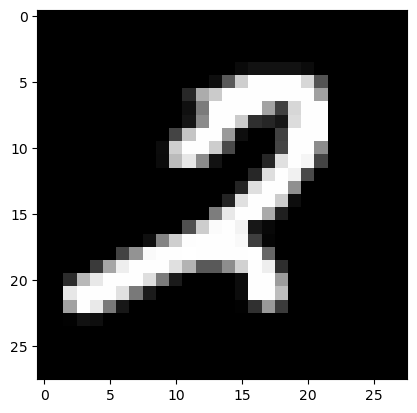

In [76]:
""" Test 1 """
import numpy as np
from sklearn.datasets import fetch_openml

# Set the printing options for numpy arrays
np.set_printoptions(precision=4, suppress=True)

test_index = 15013

test_offset = test_index
test_size = test_index + 1

target = np.array(mnist.target[test_offset : test_offset + test_size].astype(int))  # (1, 70000)

# Create a subset of the test data
test_data = np.array(mnist.data[test_offset : test_offset + test_size], dtype=float).reshape(test_size, 28, 28) / 255.0
print("test_data shape: " + str(test_data.shape))

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stability improvement
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def tanh(x):
    return np.tanh(x)

def get_image_section(layer, row_from, row_to, col_from, col_to):
    section = layer[:, row_from:row_to, col_from:col_to]
    return section.reshape(-1, 1, row_to - row_from, col_to - col_from)

# Load saved weights
kernels = np.loadtxt(name_kernels, delimiter=",").reshape(3*3, 16)  # Adjust file name as needed
weights_1_2 = np.loadtxt(name_weights_1_2, delimiter=",")  # Adjust file name as needed

# Testing loop
test_predictions = []
for i in range(test_size - test_offset):
    layer_0 = test_data[i:i + 1]
    
    sects = []
    for row_start in range(layer_0.shape[1] - kernel_rows):
        for col_start in range(layer_0.shape[2] - kernel_cols):
            sect = get_image_section(layer_0, row_start, row_start + kernel_rows, col_start, col_start + kernel_cols)
            sects.append(sect)
    
    expanded_input = np.concatenate(sects, axis=1)
    es = expanded_input.shape
    flattened_input = expanded_input.reshape(es[0] * es[1], -1)
    kernel_output = flattened_input.dot(kernels)
    layer_1 = tanh(kernel_output.reshape(es[0], -1))
    layer_2 = np.dot(layer_1, weights_1_2)
    
    predicted_class = np.argmax(layer_2)
    print(f"Predicted class: {predicted_class}")
    test_predictions.append(predicted_class)

correct_answer = target  # No need to slice again since target is already the correct size
print(f"test_predictions: {test_predictions[:10]}")  # Print first 10 predictions for verification
print(f"Correct Answer: {correct_answer[:1]}")  # Print first 10 correct answers for verification

correctly_predicted = 0
for i in range(len(test_predictions)):
    if test_predictions[i] == correct_answer[i]:
        correctly_predicted += 1
        
model_accuracy = correctly_predicted / len(test_predictions) * 100
print(f"- Model Accuracy: {model_accuracy:.2f}%")

# Take the nth image (indexed at n-1) from the training set,
# reshape from (784, ) to (28, 28) to have a valid shape for displaying purposes.
mnist_image = mnist.data[test_index].reshape(28, 28)
# Set the color mapping to grayscale to have a black background.
plt.imshow(mnist_image, cmap="gray")
# Display the image.
plt.show()